## Vehicle Detection Project by Fan Jiang

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


---


### Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

In [2]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import glob
import time
%matplotlib inline

Let's see how test images looks like:

Total samples with vehicle are:
8792
Total samples without vehicle are: 
8968


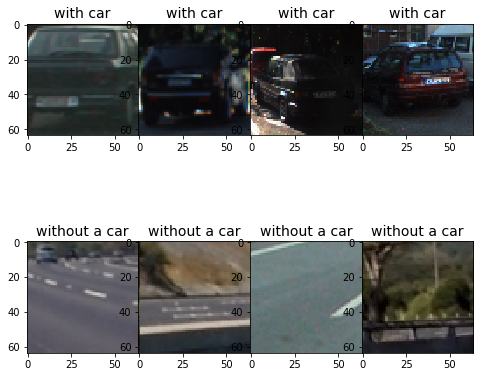

In [3]:
# Read in cars and notcars
allimages = glob.glob('../*vehicles/*/*')
cars = []
notcars = []
for image in allimages:
    if 'non' in image :
        notcars.append(image)
    else:
        cars.append(image)

print ("Total samples with vehicle are:" )
print(len(cars))
print  ("Total samples without vehicle are: ")
print(len(notcars))

figure, axis = plt.subplots(2,4, figsize=(8, 8))
figure.subplots_adjust(hspace = .001, wspace=.002)
axis = axis.ravel()
#Dispaly sample images
for index in np.arange(8):
    if index < 4:
        i = np.random.randint(0,len(cars))
        img = cv2.imread(cars[i])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        axis[index].set_title('with car', fontsize=14)
        axis[index].imshow(img)
    else:
        i = np.random.randint(0,len(notcars))
        img = cv2.imread(notcars[i])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        axis[index].set_title('without a car', fontsize=14)
        axis[index].imshow(img)

#### Define functions for feature extraction. Most functions are based on Udacity courses. 

In [4]:
# Define a function to return HOG features and visualization
# From Udacity course
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

##### Display car with its HOG feature for verification

#### Methdologies to extract HOG features

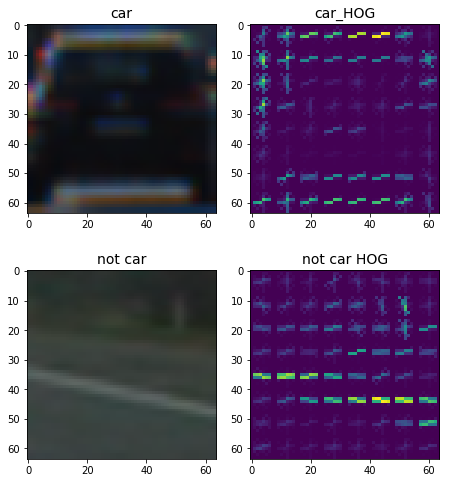

In [5]:
index = np.random.randint(0,len(cars))
hog_channel = 0
orient = 9
pix_per_cell = 8 
cell_per_block = 8

car_feature_image = mpimg.imread(cars[index])
_,car_feature = get_hog_features(car_feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
noncar_feature_image = mpimg.imread(notcars[100])
_,noncar_feature = get_hog_features(noncar_feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

figure, axis = plt.subplots(2,2, figsize=(8, 8))
figure.subplots_adjust(hspace = .3, wspace=.002)
axis = axis.ravel()

for index in np.arange(4):
        if index == 0:
            axis[index].set_title('car', fontsize=14)
            axis[index].imshow(car_feature_image)
        if index == 1:
            axis[index].set_title('car_HOG', fontsize=14)
            axis[index].imshow(car_feature)
        if index == 2:
            axis[index].set_title('not car', fontsize=14)
            axis[index].imshow(noncar_feature_image)
        if index == 3:
            axis[index].set_title('not car HOG', fontsize=14)
            axis[index].imshow(noncar_feature)

In [6]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = np.copy(image)
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

The following part will show how to create classifier. Those codes create the feature lists for the training data. All data is split to trainging dataset (80%) and test datasets (20%)

In [7]:


orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 600] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
noncar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# # Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))



Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2052


#### Use SVC to train classifier

In [8]:
# From Udacity course 

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

2.98 Seconds to train SVC...
Test Accuracy of SVC =  0.9904


### Implement a sliding-window technique and use trained classifier to search for vehicles in images.

Use classifier to search and classify cars.

In [9]:
#Define at Udaictiy course

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = np.copy(img)      
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

#Defined at Udaiciy course

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

Define functions with sliding window search for cars.

In [10]:
# Below functions are defined at Udacity course

# define function to draw box
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function that takes an image,start and stop positions in both x and y, 
# window size (x and y dimensions), and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

Experiment with different color and gradient features sets, different search window sizes and overlap.

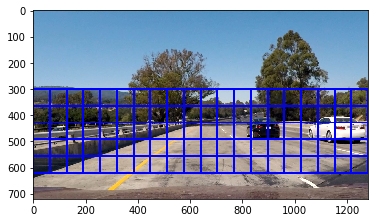

In [20]:
image = mpimg.imread('./test_images/test1.jpg')
draw_image = np.copy(image)

ystart = 300
ystop = 650
windows = slide_window(image, x_start_stop=[None,None], y_start_stop=[ystart,ystop], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

In [21]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, color_space, hog_channel, scale, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_recs = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
        
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
   
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            #test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                draw_recs.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_recs

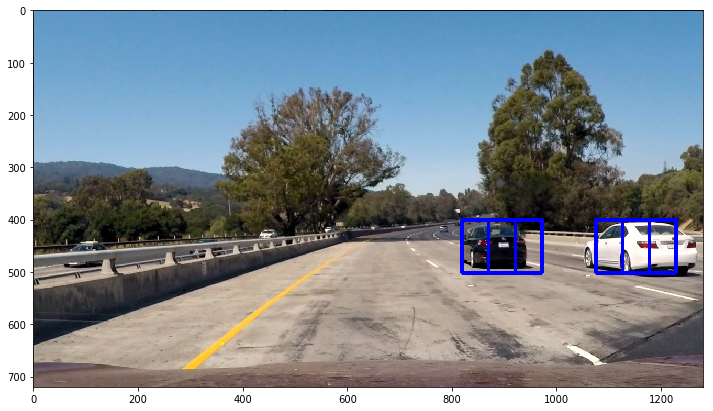

In [22]:
image = mpimg.imread('./test_images/test1.jpg')
ystart = 400
ystop = 620
scale = 1.6
draw_recs = find_cars(image, ystart, ystop, color_space, hog_channel, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
draw_images = draw_boxes(image, draw_recs)
plt.figure(figsize=(12,12))
plt.imshow(draw_images)

### Show a more efficient way to do sliding window search: multi-scale window search. 

Total multi-scale boxes:  14


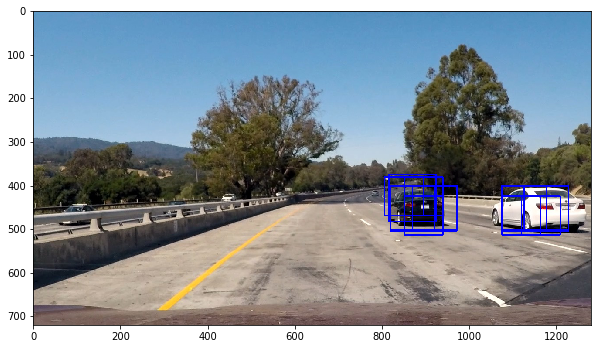

In [23]:
image = mpimg.imread('./test_images/test1.jpg')
draw_image = np.copy(image)
recs=[]

ystart = 400
ystop = 600
scale = 1.6
rec = find_cars(image, ystart, ystop, color_space, hog_channel, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)              
recs.append(rec)

ystart = 380
ystop = 670
scale = 1.4
rec = find_cars(image, ystart, ystop, color_space, hog_channel, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
recs.append(rec)


ystart = 320
ystop = 660
scale = 1.7
rec = find_cars(image, ystart, ystop, color_space, hog_channel, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
recs.append(rec)

ystart = 300
ystop = 650
scale = 1.6
rec = find_cars(image, ystart, ystop, color_space, hog_channel, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
recs.append(rec)

rectangles = [index for sublist in recs for index in sublist] 
test_image = draw_boxes(draw_image, rectangles, thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_image)
print('Total multi-scale boxes: ', len(rectangles))


After detect cars, we need to generate heat map to identify the most hot area of where the car will be, and elimite false positive result.

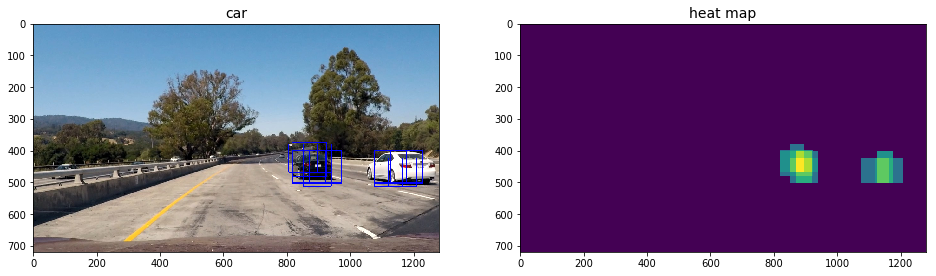

In [24]:

heat = np.zeros_like(test_image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Add heat to each box in box list
heat = add_heat(heat,rectangles)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

figure, axis = plt.subplots(1,2, figsize=(16, 16))
figure.subplots_adjust(hspace = .3, wspace=.2)
axis = axis.ravel()

for index in np.arange(2):
        if index == 0:
            axis[index].set_title('car', fontsize=14)
            axis[index].imshow(test_image)
        if index == 1:
            axis[index].set_title('heat map', fontsize=14)
            axis[index].imshow(heatmap)

Apply labels to heatmap

Found 2 cars from heat map.


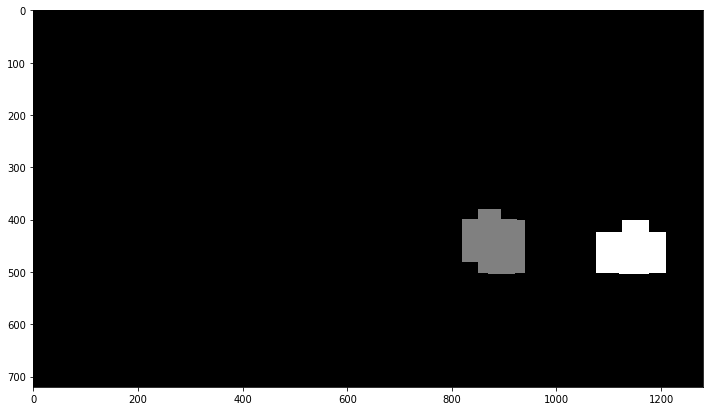

In [25]:
labels = label(heatmap)
plt.figure(figsize=(12,12))
plt.imshow(labels[0], cmap='gray')
print('Found', labels[1], 'cars from heat map.')

Next step is to draw bounding boxes around the labeled regions:

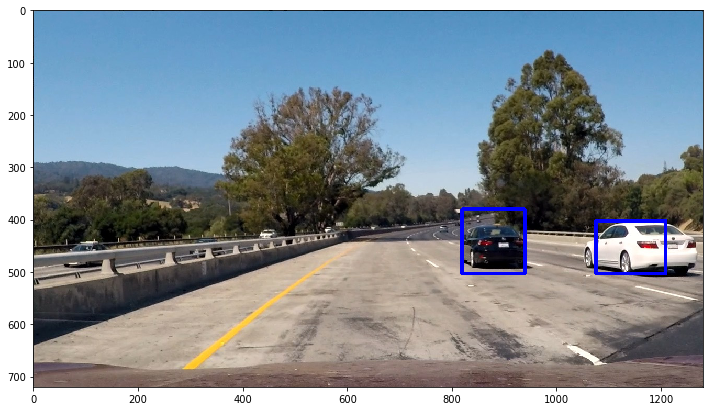

In [26]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.figure(figsize=(12,12))
plt.imshow(draw_img)

Above step describes how I train test image and draw bounding boxes on each car found in image. The next part is to combine all steps together to form a process pipeline.

In [27]:
def process_line(image):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    draw_image = np.copy(image)
    recs=[]

    ystart = 400
    ystop = 600
    scale = 1.6
    rec = find_cars(image, ystart, ystop, color_space, hog_channel, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)              
    recs.append(rec)

    ystart = 380
    ystop = 670
    scale = 1.4
    rec = find_cars(image, ystart, ystop, color_space, hog_channel, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    recs.append(rec)

    ystart = 320
    ystop = 660
    scale = 1.7
    rec = find_cars(image, ystart, ystop, color_space, hog_channel, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    recs.append(rec)

    ystart = 300
    ystop = 650
    scale = 1.6
    rec = find_cars(image, ystart, ystop, color_space, hog_channel, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    recs.append(rec)

    rectangles = [index for sublist in recs for index in sublist] 
    test_image = draw_boxes(draw_image, rectangles, thick=2)
    
    heat = add_heat(heat,rectangles)
    heat = apply_threshold(heat,2)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img


### Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

### Frame processing
In following part, I am going to process video using above defined functions.

In [28]:
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_line)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [10:14<00:00,  2.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 18min 29s, sys: 4.04 s, total: 18min 33s
Wall time: 10min 14s
